In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('..')

from fastai.conv_learner import *
PATH = "./../data/cifar10"

In [3]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
stats = (np.array([ 0.4914 ,  0.48216,  0.44653]), np.array([ 0.24703,  0.24349,  0.26159]))

In [5]:
def get_data(sz, bs):
    tfms = tfms_from_stats(stats=stats, sz=sz, aug_tfms=[RandomFlip()], pad=sz//8)
    return ImageClassifierData.from_paths(path=PATH, val_name='test', tfms=tfms, bs=bs)

In [9]:
data = get_data(32,4)

## Refactored CNN

In [6]:
class ConvLayer(nn.Module):
    def __init__(self, ni, nf):
        super().__init__()
        self.conv = nn.Conv2d(in_channels=ni, out_channels=nf, kernel_size=3, stride=2, padding=1)
    
    def forward(self, x):
        return F.relu(self.conv(x))

In [7]:
class ConvNet(nn.Module):
    def __init__(self, layers, c):
        super().__init__()
        self.layers = nn.ModuleList([ConvLayer(ni=layers[i], nf=layers[i+1]) for i in range(len(layers) - 1)])
        self.out = nn.Linear(in_features=layers[-1], out_features=c)
        
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        x = F.adaptive_max_pool2d(input=x, output_size=1)
        x = x.view(x.size(0), -1)
        return F.log_softmax(input=self.out(x), dim=-1)

In [10]:
learner = ConvLearner.from_model_data(ConvNet([3, 20, 40, 80], 10), data)
learner.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 32, 32]),
                           ('output_shape', [-1, 20, 16, 16]),
                           ('trainable', True),
                           ('nb_params', 560)])),
             ('ConvLayer-2',
              OrderedDict([('input_shape', [-1, 3, 32, 32]),
                           ('output_shape', [-1, 20, 16, 16]),
                           ('nb_params', 0)])),
             ('Conv2d-3',
              OrderedDict([('input_shape', [-1, 20, 16, 16]),
                           ('output_shape', [-1, 40, 8, 8]),
                           ('trainable', True),
                           ('nb_params', 7240)])),
             ('ConvLayer-4',
              OrderedDict([('input_shape', [-1, 20, 16, 16]),
                           ('output_shape', [-1, 40, 8, 8]),
                           ('nb_params', 0)])),
             ('Conv2d-5',
              OrderedDict([('input_shape', [-1, 40, 8, 8]),
                 

## BatchNorm CNN

In [11]:
class BNLayer(nn.Module):
    def __init__(self, ni, nf, kernel_size=3, stride=2):
        super().__init__()
        self.conv = nn.Conv2d(in_channels=ni, out_channels=nf, kernel_size=kernel_size, 
                              stride=stride, padding=1, bias=False)
        self.a = nn.Parameter(torch.zeros(nf, 1, 1))
        self.m = nn.Parameter(torch.ones(nf, 1, 1))
    
    def forward(self, x):
        x = F.relu(self.conv(x))
        x_chan = x.transpose(0, 1).contiguous().view(x.size(1), -1)
        if self.training:
            self.means = x_chan.mean(1)[:, None, None]
            self.stds = x_chan.std()[:, None, None]
        return (x - self.means) / self.stds * self.m + self.a

In [12]:
class ConvBNNet(nn.Module):
    def __init__(self, layers, c):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=5, stride=1, 
                               padding=2)
        self.layers = nn.ModuleList([BNLayer(layers[i], layers[i+1]) for i in range(len(layers) - 1)])
        self.out = nn.Linear(in_features=layers[-1], out_features=c)
    
    def forward(self, x):
        x = self.conv1(x)
        for layer in self.layers:
            x = layer(x)
        x = F.adaptive_max_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        return F.log_softmax(input=self.out(x), dim=-1)

In [13]:
learner = ConvLearner.from_model_data(ConvBNNet([10, 20, 40, 80, 160], 10), data)
learner.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 32, 32]),
                           ('output_shape', [-1, 10, 32, 32]),
                           ('trainable', True),
                           ('nb_params', 760)])),
             ('Conv2d-2',
              OrderedDict([('input_shape', [-1, 10, 32, 32]),
                           ('output_shape', [-1, 20, 16, 16]),
                           ('trainable', True),
                           ('nb_params', 1800)])),
             ('BNLayer-3',
              OrderedDict([('input_shape', [-1, 10, 32, 32]),
                           ('output_shape', [-1, 20, 16, 16]),
                           ('nb_params', 0)])),
             ('Conv2d-4',
              OrderedDict([('input_shape', [-1, 20, 16, 16]),
                           ('output_shape', [-1, 40, 8, 8]),
                           ('trainable', True),
                           ('nb_params', 7200)])),
             ('BNLayer-5',
              OrderedDict([

## Deep BatchNorm CNN

In [20]:
class ConvBNNet2(nn.Module):
    def __init__(self, layers, c):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=5, stride=1, padding=2)
        self.layers1 = nn.ModuleList([BNLayer(layers[i], layers[i+1]) for i in range(len(layers) - 1)])
        self.layers2 = nn.ModuleList([BNLayer(layers[i+1], layers[i+1], stride=1) for i in range(len(layers) - 1)])
        self.pool = nn.AdaptiveMaxPool2d(output_size=1)
        self.out = nn.Linear(in_features=layers[-1], out_features=c)
    
    def forward(self, x):
        x = self.conv1(x)
        for layer1, layer2 in zip(self.layers1, self.layers2):
            x = layer1(x)
            x = layer2(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        return F.log_softmax(input=self.out(x), dim=-1)

In [21]:
learner = ConvLearner.from_model_data(ConvBNNet2([10, 20, 40, 80, 160], 10), data)
learner.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 32, 32]),
                           ('output_shape', [-1, 10, 32, 32]),
                           ('trainable', True),
                           ('nb_params', 760)])),
             ('Conv2d-2',
              OrderedDict([('input_shape', [-1, 10, 32, 32]),
                           ('output_shape', [-1, 20, 16, 16]),
                           ('trainable', True),
                           ('nb_params', 1800)])),
             ('BNLayer-3',
              OrderedDict([('input_shape', [-1, 10, 32, 32]),
                           ('output_shape', [-1, 20, 16, 16]),
                           ('nb_params', 0)])),
             ('Conv2d-4',
              OrderedDict([('input_shape', [-1, 20, 16, 16]),
                           ('output_shape', [-1, 20, 16, 16]),
                           ('trainable', True),
                           ('nb_params', 3600)])),
             ('BNLayer-5',
              OrderedDict

## ResNet

In [24]:
class ResNetLayer(BNLayer):
    def forward(self, x): 
        return x + super().forward(x)

In [25]:
class ResNet(nn.Module):
    def __init__(self, layers, c, p=0.5):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=layers[0], kernel_size=5, stride=1, padding=2)
        self.layers1 = nn.ModuleList([BNLayer(layers[i], layers[i+1]) for i in range(len(layers) - 1)])
        self.layers2 = nn.ModuleList([ResNetLayer(layers[i+1], layers[i+1], stride=1) for i in range(len(layers) - 1)])
        self.layers3 = nn.ModuleList([ResNetLayer(layers[i+1], layers[i+1], stride=1) for i in range(len(layers) - 1)])
        self.pool = nn.AdaptiveMaxPool2d(output_size=1)
        self.out = nn.Linear(in_features=layers[-1], out_features=c)
        self.drop = nn.Dropout(p)
    
    def forward(self, x):
        x = self.conv1(x)
        for layer1, layer2, layer3 in zip(self.layers1, self.layers2, self.layers3):
            x = layer3(layer2(layer1(x)))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.drop(x)
        return F.log_softmax(input=self.out(x), dim=-1)

In [27]:
learner = ConvLearner.from_model_data(ResNet([10, 20, 40, 80, 160], 10), data)
learner.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 32, 32]),
                           ('output_shape', [-1, 10, 32, 32]),
                           ('trainable', True),
                           ('nb_params', 760)])),
             ('Conv2d-2',
              OrderedDict([('input_shape', [-1, 10, 32, 32]),
                           ('output_shape', [-1, 20, 16, 16]),
                           ('trainable', True),
                           ('nb_params', 1800)])),
             ('BNLayer-3',
              OrderedDict([('input_shape', [-1, 10, 32, 32]),
                           ('output_shape', [-1, 20, 16, 16]),
                           ('nb_params', 0)])),
             ('Conv2d-4',
              OrderedDict([('input_shape', [-1, 20, 16, 16]),
                           ('output_shape', [-1, 20, 16, 16]),
                           ('trainable', True),
                           ('nb_params', 3600)])),
             ('ResNetLayer-5',
              Ordered

 69%|██████████████████████████████████████████████▊                     | 8604/12500 [08:25<03:51, 16.79it/s, loss=8.82]

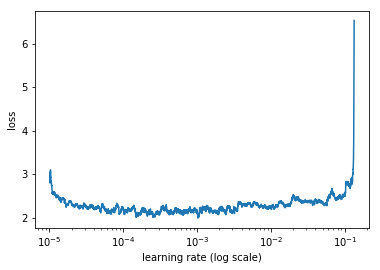

 69%|██████████████████████████████████████████████▊                     | 8604/12500 [08:40<03:51, 16.79it/s, loss=8.82]

In [28]:
learner.lr_find()
learner.sched.plot()

In [16]:
%time learner.fit(1e-1, 2)

epoch      trn_loss   val_loss   accuracy                                                                                
    0      2.36045    2.399245   0.1       
    1      2.294301   2.331147   0.1693                                                                                  
Wall time: 10min 51s


[array([2.33115]), 0.1693]

In [17]:
lr = 1e-2
lrs = np.array([lr/9, lr/3, lr])
%time learner.fit(lrs=lrs, 2)

SyntaxError: positional argument follows keyword argument (<unknown>, line 1)